# Local NDVI Data Frame Time Series Harmonization

This notebook outlines how `pixltsnorm` can be used to harmonize NDVI timeseries, as data frames, from three different landsat sensors.

This tutorial uses the "local" (or "per-pixel") approach, which fits a model to each pixel-based time series.

First, let's set import required packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pixltsnorm import DataFrameHarmonizer, unify_and_extract_timeseries

Now let's load data. Time series data must be read as a pandas dataframe, where each row represents a pixel and each column is an ovservation at a date.

In [2]:
df_l5 = pd.read_csv("landsat5_ndvi.csv")  # NDVI timeseries from landsat 5
df_l7 = pd.read_csv("landsat7_ndvi.csv")  # NDVI timeseries from landsat 7
df_l8 = pd.read_csv("landsat8_ndvi.csv")  # NDVI timeseries from landsat 8

print("Landsat 5 NDVI Data (df_l5) shape:", df_l5.shape)
print("Landsat 7 NDVI Data (df_l7) shape:", df_l7.shape)
print("Landsat 8 NDVI Data (df_l8) shape:", df_l8.shape)

# For example:
df_l5.head()

Landsat 5 NDVI Data (df_l5) shape: (130, 122)
Landsat 7 NDVI Data (df_l7) shape: (130, 202)
Landsat 8 NDVI Data (df_l8) shape: (130, 117)


,1989-03,1989-04,1989-06,1989-09,1990-04,1990-07,1990-10,1990-11,1990-12,1991-01,...,2009-06,2009-11,2009-12,2010-04,2010-11,2011-01,2011-07,2011-10,lon,lat
0,0.682884,0.838200,0.751083,0.661217,0.769227,0.739458,0.543756,0.618083,0.778853,0.832019,...,0.750159,NaN,0.512932,0.796805,0.711939,0.525048,0.685980,0.617051,46.803529,-16.319918
1,0.691476,0.801529,0.793889,0.666808,0.740608,0.756344,0.586325,0.618083,0.783292,0.835941,...,0.755196,NaN,0.474799,0.821274,0.689429,0.549418,0.718248,0.603297,46.803798,-16.319918
2,0.718777,0.805915,0.798225,0.666808,0.790801,0.766380,0.550005,0.602386,0.791835,0.824352,...,0.793632,NaN,0.433317,0.823839,0.711965,0.552943,0.723567,0.572680,46.804068,-16.319918
3,0.687254,0.840833,0.793889,0.638068,0.761176,0.756265,0.550005,0.613439,0.776662,0.829965,...,0.789485,NaN,0.443734,0.799750,0.692897,0.542402,0.723567,0.603297,46.804337,-16.319918
4,0.695586,0.848243,0.761615,0.638068,0.765259,0.730655,0.550005,0.625302,0.776662,0.822375,...,0.789485,NaN,0.508014,0.818614,0.693050,0.563269,0.712686,0.608697,46.804607,-16.319918


Notice that each column is a monthly value of NDVI and the last two columns are `lon` and `lat` representing the pixel center. These will automatically be dropped before any analysis. 

Now, let's create the harmonized output. 

We'll put these into a list `[df_l5, df_l7, df_l8]`, then harmonize them.
By default, the last DataFrame (df_l8) will become the target scale.

Note: If you want a different target, set `target_index` in .fit().

In [3]:
unharmonized = [df_l5, df_l7, df_l8]

harm_df = DataFrameHarmonizer(method='linear', approach='local', outlier_threshold=0.2)
harm_df.fit(unharmonized)  # by default, target_index = 2 => df_l8

harmonized = harm_df.get_harmonized_dfs(unharmonized)

Now, we can visualize this harmonization. To do this, we need to unify the date columns across the multiple DataFrames. `unify_and_extract_timeseries` is a utility function that will do this for us. It will give us the dates as well as the raw time series arrays at a given row index. For the first row (`row_index=0`):

In [4]:
unharmonized_arrays, dates, time_axis = unify_and_extract_timeseries(unharmonized, row_index=0)
harmonized_arrays, dates, time_axis = unify_and_extract_timeseries(harmonized, row_index=0)

l5_unharmonized = unharmonized_arrays[0]
l7_unharmonized = unharmonized_arrays[1]
l8_unharmonized = unharmonized_arrays[2]

l5_harmonized = harmonized_arrays[0]
l7_harmonized = harmonized_arrays[1]
l8_harmonized = harmonized_arrays[2]

# note, l8_raw will equal l8_harmonized:
mask = ~np.isnan(l8_unharmonized) & ~np.isnan(l8_harmonized)
print(np.array_equal(l8_unharmonized[mask], l8_harmonized[mask]))

True


Plotting the time series before the normalization:

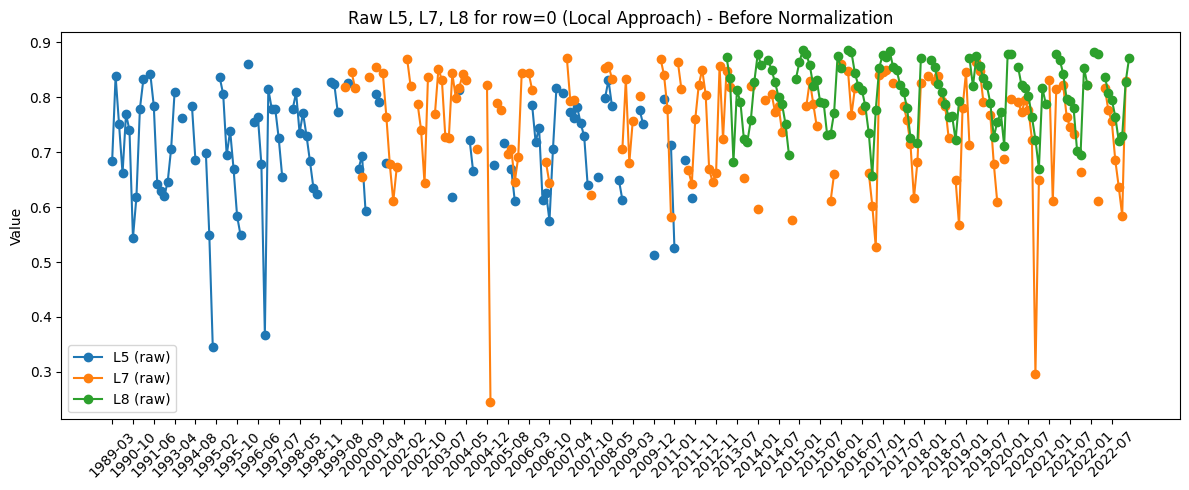

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(time_axis, l5_unharmonized, label="L5 (raw)", marker="o")
plt.plot(time_axis, l7_unharmonized, label="L7 (raw)", marker="o")
plt.plot(time_axis, l8_unharmonized, label="L8 (raw)", marker="o")
label_indices = time_axis[::6]
label_dates  = [dates[i].strftime("%Y-%m") if not pd.isnull(dates[i]) else "" for i in label_indices]
plt.xticks(label_indices, label_dates, rotation=45)
plt.ylabel("Value")
plt.title("Raw L5, L7, L8 for row=0 (Local Approach) - Before Normalization")
plt.legend()
plt.tight_layout()
plt.show()

And after:

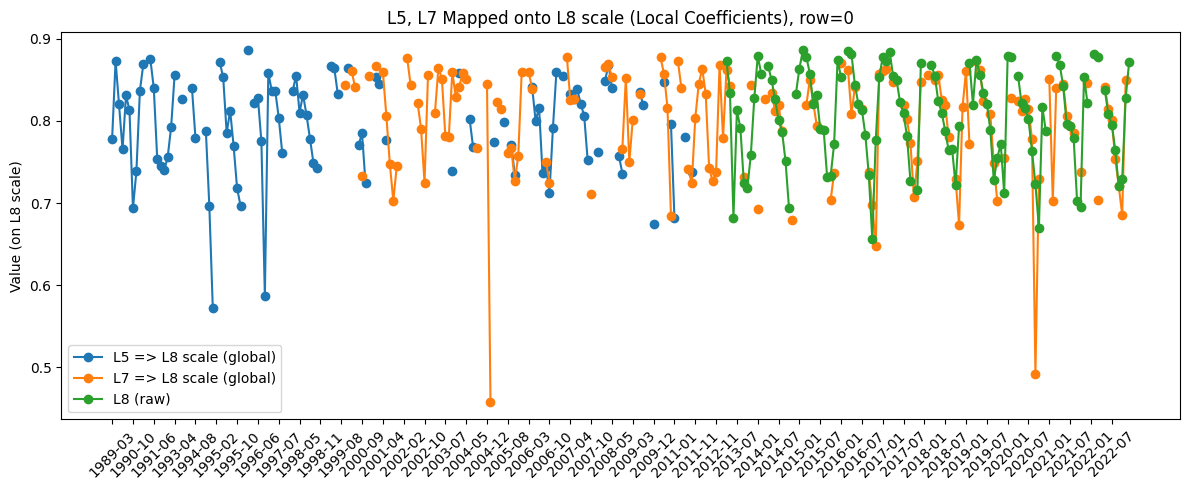

In [6]:
arrays, dates, time_axis = unify_and_extract_timeseries([df_l5, df_l7, df_l8], row_index=0)

plt.figure(figsize=(12, 5))
plt.plot(time_axis, l5_harmonized,   label="L5 => L8 scale (global)", marker="o")
plt.plot(time_axis, l7_harmonized,   label="L7 => L8 scale (global)", marker="o")
plt.plot(time_axis, l8_harmonized,     label="L8 (raw)", marker="o")
label_indices = time_axis[::6]
label_dates  = [dates[i].strftime("%Y-%m") if not pd.isnull(dates[i]) else "" for i in label_indices]
plt.xticks(label_indices, label_dates, rotation=45)
plt.ylabel("Value (on L8 scale)")
plt.title("L5, L7 Mapped onto L8 scale (Local Coefficients), row=0")
plt.legend()
plt.tight_layout()
plt.show()

Finally, combining the two yields:

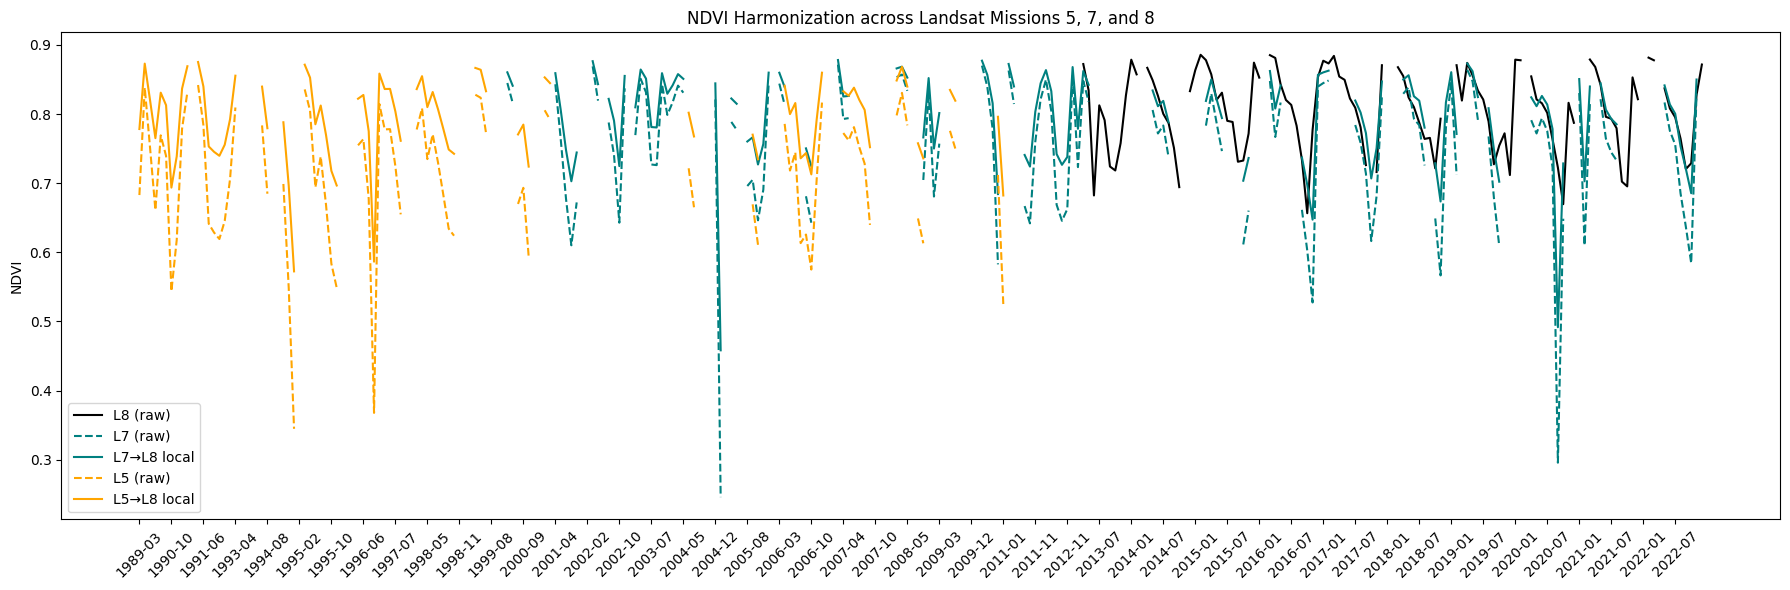

In [7]:
plt.figure(figsize=(18, 6))

plt.plot(time_axis, l8_unharmonized, label="L8 (raw)", color="black", linestyle="-")
plt.plot(time_axis, l7_unharmonized,    label="L7 (raw)",    color="teal",  linestyle="--")
plt.plot(time_axis, l7_harmonized,  label="L7→L8 local",color="teal",  linestyle="-")
plt.plot(time_axis, l5_unharmonized,    label="L5 (raw)",    color="orange", linestyle="--")
plt.plot(time_axis, l5_harmonized,  label="L5→L8 local",color="orange", linestyle="-")
label_indices = time_axis[::6]
label_dates  = [dates[i].strftime("%Y-%m") if not pd.isnull(dates[i]) else "" for i in label_indices]
plt.xticks(label_indices, label_dates, rotation=45)
plt.ylabel("NDVI")
plt.title("NDVI Harmonization across Landsat Missions 5, 7, and 8")
plt.legend()
plt.tight_layout()
plt.show()